In [1]:
from clipppy import load_config
from matplotlib import pyplot as plt
import torch, pyro, numpy as np 
import collections, os
import corner
from ruamel.yaml import YAML


import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *
from channels import split_channels

In [2]:
VERSION_NAME = '1810_1'

STORE_DIR = 'training_data_lens_source'
STORE_DIR_VERSION = os.path.join(STORE_DIR, VERSION_NAME)
os.makedirs(STORE_DIR, exist_ok = True)
os.makedirs(STORE_DIR_VERSION, exist_ok = True)

PARAMS = YAML().load(open('params.yaml'))['lens_source']

In [3]:
losses_name = os.path.join(STORE_DIR_VERSION, f'losses_{VERSION_NAME}.pt')
guide_name  = os.path.join(STORE_DIR_VERSION, f'guide_{VERSION_NAME}.pt')

In [4]:
config = load_config('config_gen_mock_lens_source.yaml')
model = config.umodel
guide = config.guide

obs = config.conditioning['image']

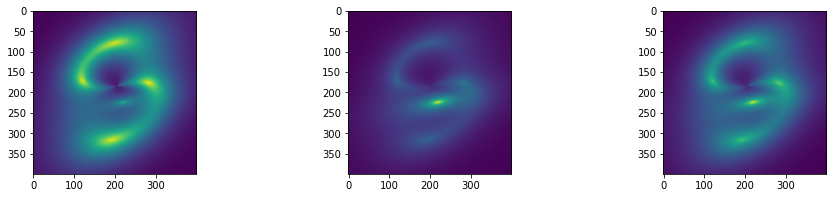

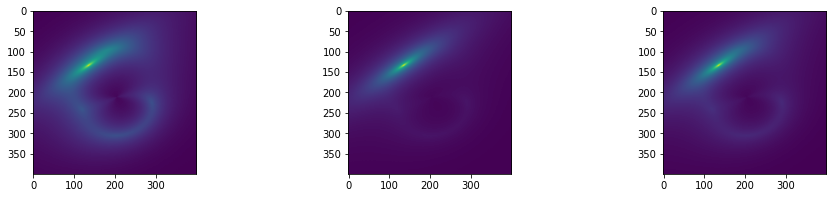

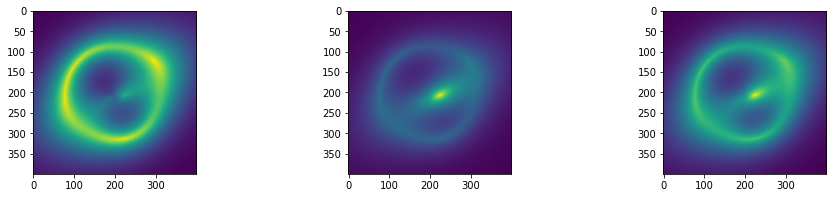

In [5]:
if model.n_channels >= 2:
    plot_imshow(split_channels(model()), size_y = 3)
    plot_imshow(split_channels(model()), size_y = 3)
    plot_imshow(split_channels(obs), size_y = 3)
else:
    plot_imshow([model(), model(), obs, obs], size_y = 3)

In [6]:
from clipppy.stochastic import Sampler

def set_init(values):
    for lens in values:
        for spec in lens.stochastic_specs.values():
            if isinstance(spec, Sampler):
                name = lens.stochastic_name + '/' + spec.name
                if name in PARAMS['init']: 
                    spec.init = spec.infer['init'] = PARAMS['init'][name]
                    print(f'{name} \t set to {spec.init}')

                    
model.lenslight['sersic2'].stochastic_specs['phi'] = PARAMS['truth']['sersic2/phi']
                    
set_init(model.lenslight.values())
set_init(model.alphas.values())
set_init(model.sources.values())



sersic2/x 	 set to 0
sersic2/y 	 set to 0
sersic2/q 	 set to 1.0
sersic2/index 	 set to 1.0
sersic2/r_e 	 set to 1.0
sersic2/I_e 	 set to 1.0
ext/gamma_1 	 set to 0.0
ext/gamma_2 	 set to 0.0
main/phi 	 set to 0.5
main/q 	 set to 0.5
main/r_ein 	 set to 1.42
main/x 	 set to 0.0
main/y 	 set to 0.0


/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:113: RuntimeWarning: Setting items on StochasticSpecs by name is frowned upon and only supports explicitly named specs at the first level.
  warn(f'Setting items on {type(self).__name__} by name is frowned upon'
/home/eliasd/lensing/clipppy/src/clipppy/stochastic/stochastic.py:129: RuntimeWarning: Iterating values from StochasticSpecs is frowned upon and returns the raw specs!
  warn(f'Iterating values from {type(self).__name__} is frowned upon'


In [7]:
# for i in range(nbatch):
#     print(f'starting batch {i}')
    
#     values = [model.lenslight.values(), model.alphas.values(), model.sources.values()]
    
#     for m in values:
#         set_init(values)
        
#     pyro.clear_param_store()
#     guide.setup()
#     losses = []

In [8]:
guide.setup()

guide

Guide(
  (MultivariateNormal): MultivariateNormalSamplingGroup(13 sites, torch.Size([13]))
)

In [9]:
if not os.path.isfile(guide_name):
    print('Training!')

    guide.train() 
    # losses += config.fit(lr=1e-2, n_steps=1000)
    losses = config.fit()
    
    torch.save(losses, losses_name)
    torch.save(guide, guide_name)

else: 
    print('Already trained!')

print('Loading!')
guide = config.guide = torch.load(guide_name)
losses = torch.load(losses_name)

Training!


  0%|          | 0/5000 [00:00<?, ?it/s]

ValueError: The parameter scale_tril has invalid values
                   Trace Shapes:      
                    Param Sites:      
          MultivariateNormal.loc    13
        MultivariateNormal.scale    13
MultivariateNormal.corr_cholesky 13 13
                   Sample Sites:      

In [ ]:
plot_log(losses, size_y = 3)

In [ ]:
def plot_guide(nsamples = 1000):
    
    params = PARAMS['truth']
    
    
    with pyro.plate('plate', nsamples):
        ppd = config.guide()
    
    ppd = {key: val for key, val in ppd.items()}
    labels = [f'{name}={truth:.2f}' for name, truth in params.items()]
    truths = [params.get(k, None) for k in ppd.keys()]
    
    print(f'{"parameter":<15} {"truth":<8} {"mean":17} {"sigma?"}')
    for (k, v), truth in zip(ppd.items(), truths): 
        print(f'{k:<15} {truth:<7} {v.mean():+.5f} ± {v.std():.5f} ({truth}{v.mean()-truth:+f}: {abs((truth - v.mean()) / v.std()):.1f}-sigma)')
    


    return corner.corner( np.stack([v.detach().numpy() for v in ppd.values()], -1), 
                         truths = truths, labels = labels);


plot_guide();

In [ ]:
def plot_fit_resids(nsamples = 1000):
    pred = torch.stack([config.ppd()['model_trace'].nodes['mu']['value'] for i in range(nsamples)], 0).mean(0)
        
#     obs = config.conditioning['image']
        
    if model.n_channels >= 2:
        obss  = split_channels(obs)
        preds = split_channels(pred)
        diffs = (obss - preds)
        plots = torch.cat((obss, preds, diffs))
        titles = ['truth c_1', 'truth c_2', 'truth total', 'pred c_1', 'pred c_2', 'pred total', 'diff c_1', 'diff c_2', 'diff total']
        return plot_imshow(plots = plots, nrows = 3, colorbar = True, titles = titles)
    
    else:
        plots = [obs, pred, obs - pred]
        titles = ['truth', 'mu pred', 'diff truth and mu pred', 'truth', 'mode pred', 'diff truth and mode pred', 'truth', 'mean pred', 'diff truth and mean pred', 'mode pred', 'mean pred', 'diff mode pred and mean pred']
    
        return plot_imshow(plots = plots, colorbar = True, titles = titles)

plot_fit_resids(10)